# Face Segmentation

## Setup / Imports

In [3]:
# Standard imports
import sys
import importlib
import pandas as pd
import numpy as np
import re

# Imports for plotting
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Are we running on local or colab?
if 'edwardrees' in sys.exec_prefix:
    device_loc = 'local'
else:
    device_loc = 'colab'

# Print where running
print('Running on', device_loc)

# Mount drive if on colab
if device_loc == 'colab':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

# Add local drive to path if running on colab
if device_loc == 'local':
    dir_ = '.'
    sys.path.append('./tools')
elif device_loc == 'colab':
    dir_ = 'drive/My Drive/GA/Capstone'
    sys.path.append(dir_)
    sys.path.append(f'{dir_}/tools')


# Images and loading
from skimage import io, util
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Progress bars, tqdm.notebook doesn't work on colab
if device_loc == 'colab':
    !pip install --force https://github.com/chengs/tqdm/archive/colab.zip
    from tqdm import tqdm_notebook as tqdm
elif device_loc == 'local':
    from tqdm.notebook import tqdm

# Import my functions
import image_processing as ip
import label_processing as lbp
import feature_processing as ftp

# Models
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import skimage.measure

Running on local


## Constants and Setup

In [4]:
# Better colour map for plotting labels
newcolors = cm.get_cmap('rainbow', 256)(np.linspace(0, 1, 10))
pink = np.array([0, 0, 0, 1])
newcolors[0, :] = pink
newcmp = ListedColormap(newcolors)

In [5]:
# The following dictionary indiciates in r-g-b what the colors are in the original labels
label_dict = {
    'mouth': ['0-255-0', 1],
    'skin': ['255-255-0', 6],
    'hair': ['127-0-0', 5],
    'padding': ['0-0-0', 0],
    'nose': ['0-255-255', 2],
    'eyes': ['0-0-255', 3],
    'background': ['255-0-0', 7]
}

# List to convert numerical label to class label
output_labels = [
    'nc',
    'mouth',
    'nose',
    'left eye',
    'right eye',
]

# What size we should make the images
IMG_SHAPE = (600, 600)

# Dataset locations
seg_v2_RGB_dir = dir_+'/rawdata/FASSEG_v2/RGB'
seg_v2_labels_dir = dir_+'/rawdata/FASSEG_v2/Labels'
seg_v3_RGB_dir = dir_+'/rawdata/FASSEG_v3/RGB'
seg_v3_labels_dir = dir_+'/rawdata/FASSEG_v3/Labels'

#real_dir = dir_+'/rawdata/real_and_fake_face/training_real'
#fake_dir = dir_+'/rawdata/real_and_fake_face/training_fake'

In [6]:
def reload_modules():
    '''
    Reload my custom modules in case something has changed
    '''   
    importlib.reload(ip)
    importlib.reload(lbp)
    importlib.reload(ftp)

## FASSEG functions

In [7]:
def score_seg_model(model, X_test, y_test):
    model.verbose = 0
    print('Accuracy Score', model.score(X_test, y_test))
    y_test_predict = model.predict(X_test)
    
    print(classification_report(y_test, y_test_predict, target_names=output_labels))

In [150]:
def view_prediction(model, img, feature_params, **kwargs):

    y_real_predict = model.predict(ftp.create_features(img, feature_params))
    
    n_imgs = 2
    
    if 'ground_truth' in kwargs:
        n_imgs += 1
        gt = n_imgs-1
    
    if 'overlap' in kwargs:
        n_imgs += 1
        ovl = n_imgs-1
    
    Y_predict = y_real_predict.reshape(img.shape[:2])
    
    fig, ax = plt.subplots(ncols=n_imgs, figsize=(5*n_imgs, 6))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(img)
    ax[1].imshow(Y_predict, cmap=newcmp)
    ax[0].set_title('Image')
    ax[1].set_title('Segmented Image')
    
    if 'ground_truth' in kwargs:
        ax[gt].axis('off')
        ax[gt].imshow(kwargs['ground_truth'], cmap=newcmp)
        ax[gt].set_title('Ground Truth')
    
    if 'overlap' in kwargs:
        ax[ovl].axis('off')
        ax[ovl].imshow(img)
        ax[ovl].imshow(Y_predict, alpha = kwargs['overlap'], cmap = newcmp)
        ax[ovl].set_title('Prediction overlap')

In [99]:
def view_data(X, Y, index):
    img = X[index]
    label = Y[index]
    
    fig, ax = plt.subplots(ncols=3, figsize=(15, 6))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(img)
    ax[1].imshow(label, cmap=newcmp)        
    ax[2].imshow(img)
    ax[2].imshow(label, alpha=0.25, cmap=newcmp)
    ax[0].set_title('Image')
    ax[1].set_title('Segmented Image')
    ax[2].set_title('Superimpsed')

## FASSEG Loading / Pre-processing


In [76]:
# Labels have some noise so segment them to obtain clean categories,
force_recalculate = False

if not os.path.exists('./data/segmentation/imgs_array.npz') or force_recalculate:

    # Check that the segmentation folder exists
    if not os.path.exists('./data/segmentation'):
        os.makedirs('./data/segmentation')
        
    # Load images from FASSEG V2 database and save the result as two lists
    seg_v2_RGB, seg_v2_labels = ip.load_images(seg_v2_RGB_dir, seg_v2_labels_dir)

    # Load images from FASSEG V3 database and save the result as two lists
    seg_v3_RGB, seg_v3_labels = ip.load_images(seg_v3_RGB_dir, seg_v3_labels_dir)

    # Combine V2 and V3 into a combined list 
    seg_v2_v3_RGB = seg_v2_RGB + seg_v3_RGB
    seg_v2_v3_labels = seg_v2_labels + seg_v3_labels

    # Convert list of images to numpy array
    X = ip.convert_images_to_array(seg_v2_v3_RGB, IMG_SHAPE, method='zero_pad')
    Y = ip.convert_images_to_array(seg_v2_v3_labels, IMG_SHAPE, method='zero_pad')
    
    # Segment the Y labels
    Y = lbp.segment_labeled_images(Y, n_clusters=7, label_dict=label_dict)
    
    # Save the results as this takes a while to run
    np.savez_compressed('./data/segmentation/imgs_array.npz', imgs=X, labels=Y)
    print('Saved semgentation labels')

else:
    # Else Load the segmented labels if
    loaded = np.load('./data/segmentation/imgs_array.npz')
    X = loaded['imgs']
    Y = loaded['labels']
    print('Loaded semgentation labels')

Loaded semgentation labels


In [77]:
# Downsample the images and convert to float, must divide the original IMG_SHAPE
ds_shape = (150,150)
ds_kernel = (IMG_SHAPE[0]//ds_shape[0],IMG_SHAPE[1]//ds_shape[1])
X_ds = ip.resize_images(X, ds_shape, convert_to_ubyte=False, preserve_range=False)

# Downsample labels by max pooling, use (4,4) to ma
Y_ds = lbp.max_pool_labels(Y, kernel = (4,4), single_img=False)

Resizing images: 100%|██████████| 80/80 [00:02<00:00, 28.70it/s]


In [100]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_ds,
                                                    Y_ds,
                                                    shuffle=True,
                                                    random_state=0,
                                                    train_size=0.7)

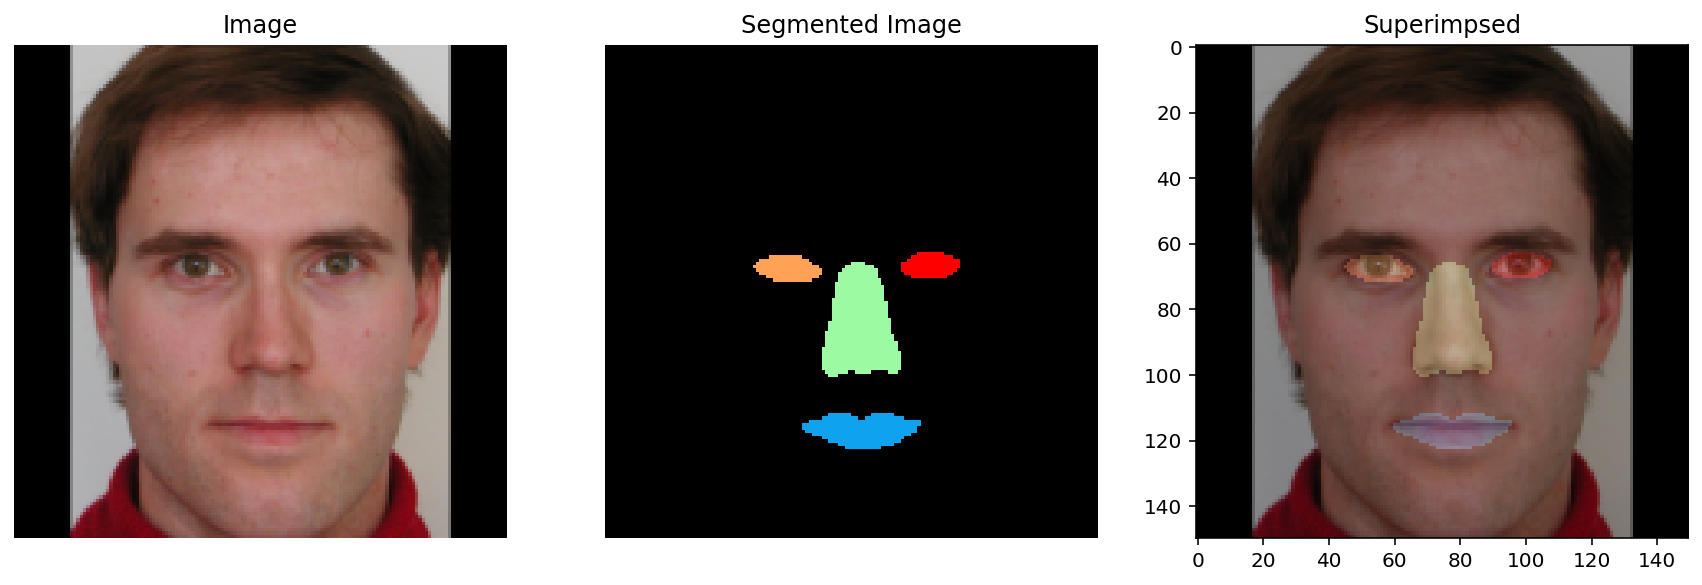

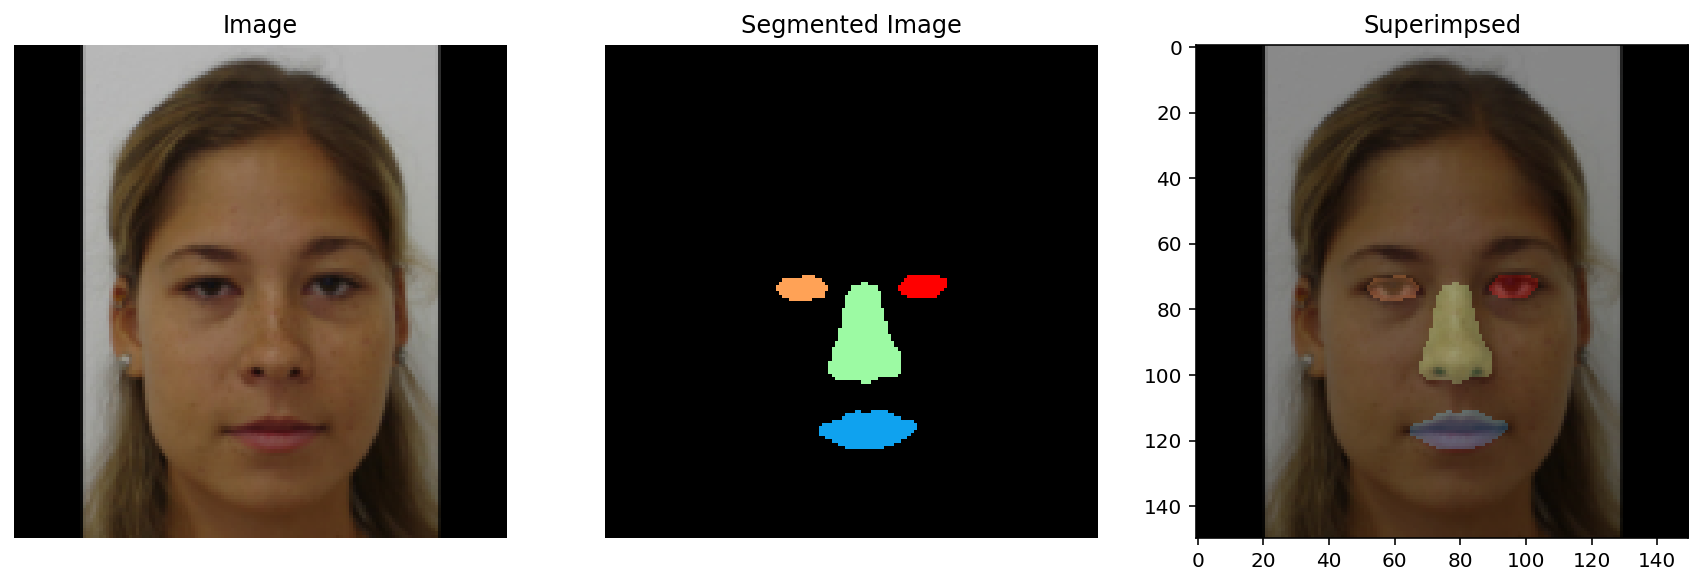

In [101]:
# Inspect some of the images
view_data(X_train, Y_train, 49)
view_data(X_train, Y_train, 10)

## Model 1 - RF No HOG

In [168]:
# Reload modules
reload_modules()

feature_params = {'color': 'gray' , 'loc': True}

# Create preditor features
X_train_f = ftp.create_features(X_train, feature_params)
X_test_f = ftp.create_features(X_test, feature_params)

In [169]:
rfc1 = RandomForestClassifier(n_estimators=30, verbose=0, n_jobs=-1)
rfc1.fit(X_train_f, Y_train.ravel());

In [170]:
score_seg_model(rfc1, X_test_f, Y_test.ravel())

Accuracy Score 0.972524074074074
              precision    recall  f1-score   support

          nc       0.98      0.99      0.99    517722
       mouth       0.62      0.57      0.59      6234
        nose       0.73      0.72      0.72     10331
    left eye       0.62      0.51      0.56      2806
   right eye       0.65      0.50      0.56      2907

    accuracy                           0.97    540000
   macro avg       0.72      0.66      0.69    540000
weighted avg       0.97      0.97      0.97    540000



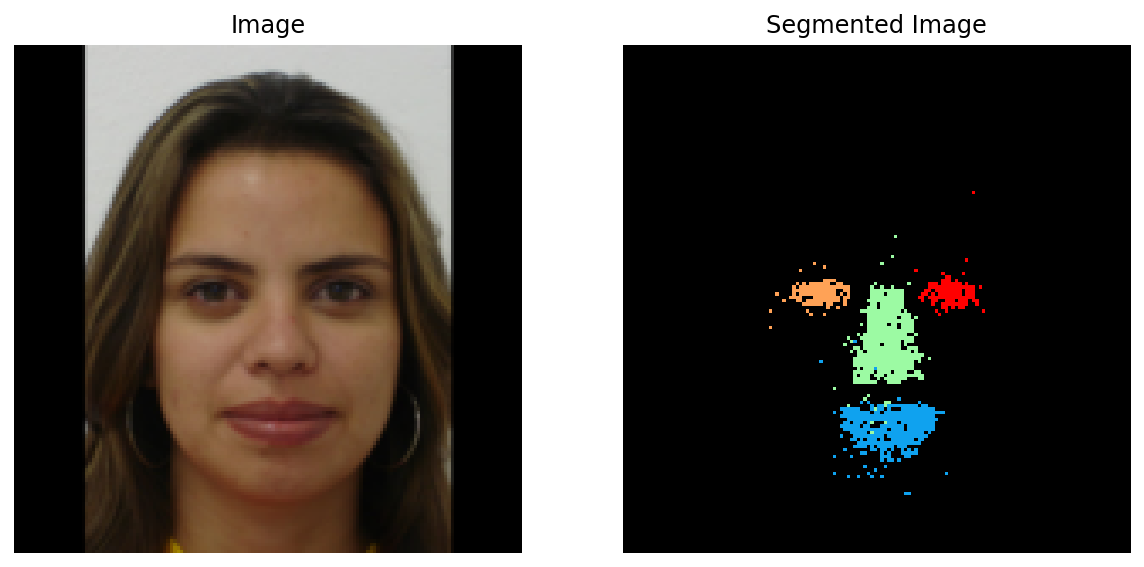

In [171]:
view_prediction(rfc1, X_test[10], feature_params)

## Model 2 - RF with HOG

In [174]:
# Reload moducles
reload_modules()

feature_params = {'color': 'color' , 'loc': True, 'hog': (15,15)}

# Create preditor features
X_train_f = ftp.create_features(X_train,
                                feature_params)
X_test_f = ftp.create_features(X_test,
                               feature_params)

In [175]:
rfc2 = RandomForestClassifier(n_estimators=30, verbose=0, n_jobs=-1)
rfc2.fit(X_train_f, Y_train.ravel());

In [177]:
score_seg_model(rfc2,X_test_f, Y_test.ravel())

Accuracy Score 0.9780148148148148
              precision    recall  f1-score   support

          nc       0.98      0.99      0.99    517722
       mouth       0.80      0.54      0.64      6234
        nose       0.82      0.70      0.76     10331
    left eye       0.80      0.52      0.63      2806
   right eye       0.79      0.50      0.61      2907

    accuracy                           0.98    540000
   macro avg       0.84      0.65      0.73    540000
weighted avg       0.98      0.98      0.98    540000



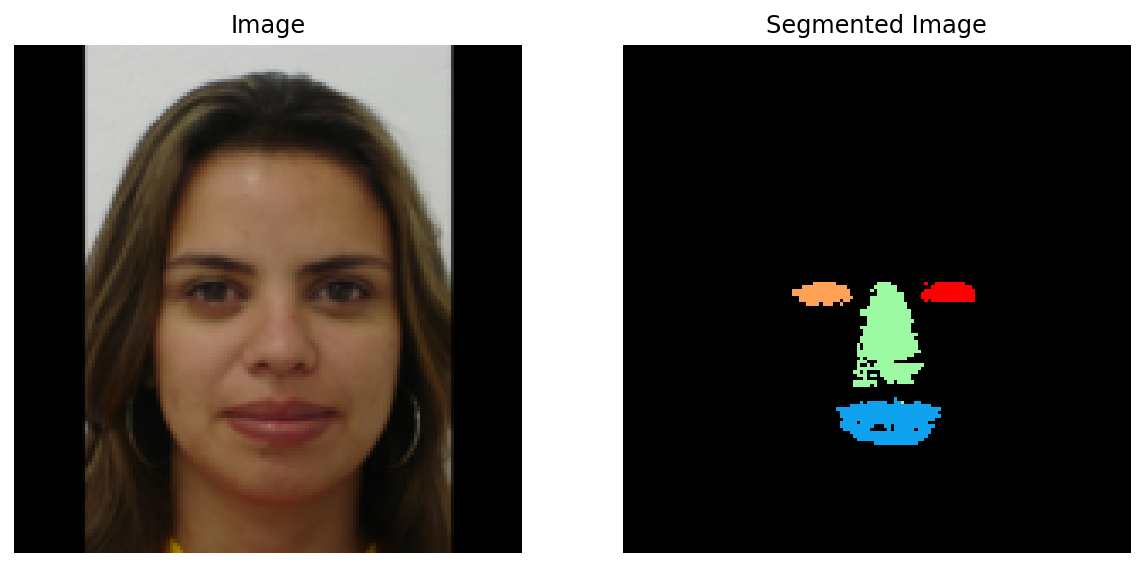

In [178]:
view_prediction(rfc2, X_test[10], feature_params)

## Model 3  - Adaboost with HOG

In [135]:
feature_params = {'color': 'color' , 'loc': True, 'hog': (15,15)}

# Create preditor features
X_train_f = ftp.create_features(X_train,
                                feature_params)
X_test_f = ftp.create_features(X_test,
                               feature_params)

In [194]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth = 30)
ada_boost = AdaBoostClassifier(base_estimator=dtc, n_estimators=10, random_state=451)

ada_boost.fit(X_train_f, Y_train.ravel());

In [195]:
score_seg_model(ada_boost, X_test_f, Y_test.ravel())

Accuracy Score 0.9774277777777778
              precision    recall  f1-score   support

          nc       0.98      0.99      0.99    517722
       mouth       0.76      0.59      0.67      6234
        nose       0.79      0.71      0.75     10331
    left eye       0.73      0.56      0.63      2806
   right eye       0.75      0.54      0.63      2907

    accuracy                           0.98    540000
   macro avg       0.80      0.68      0.73    540000
weighted avg       0.98      0.98      0.98    540000



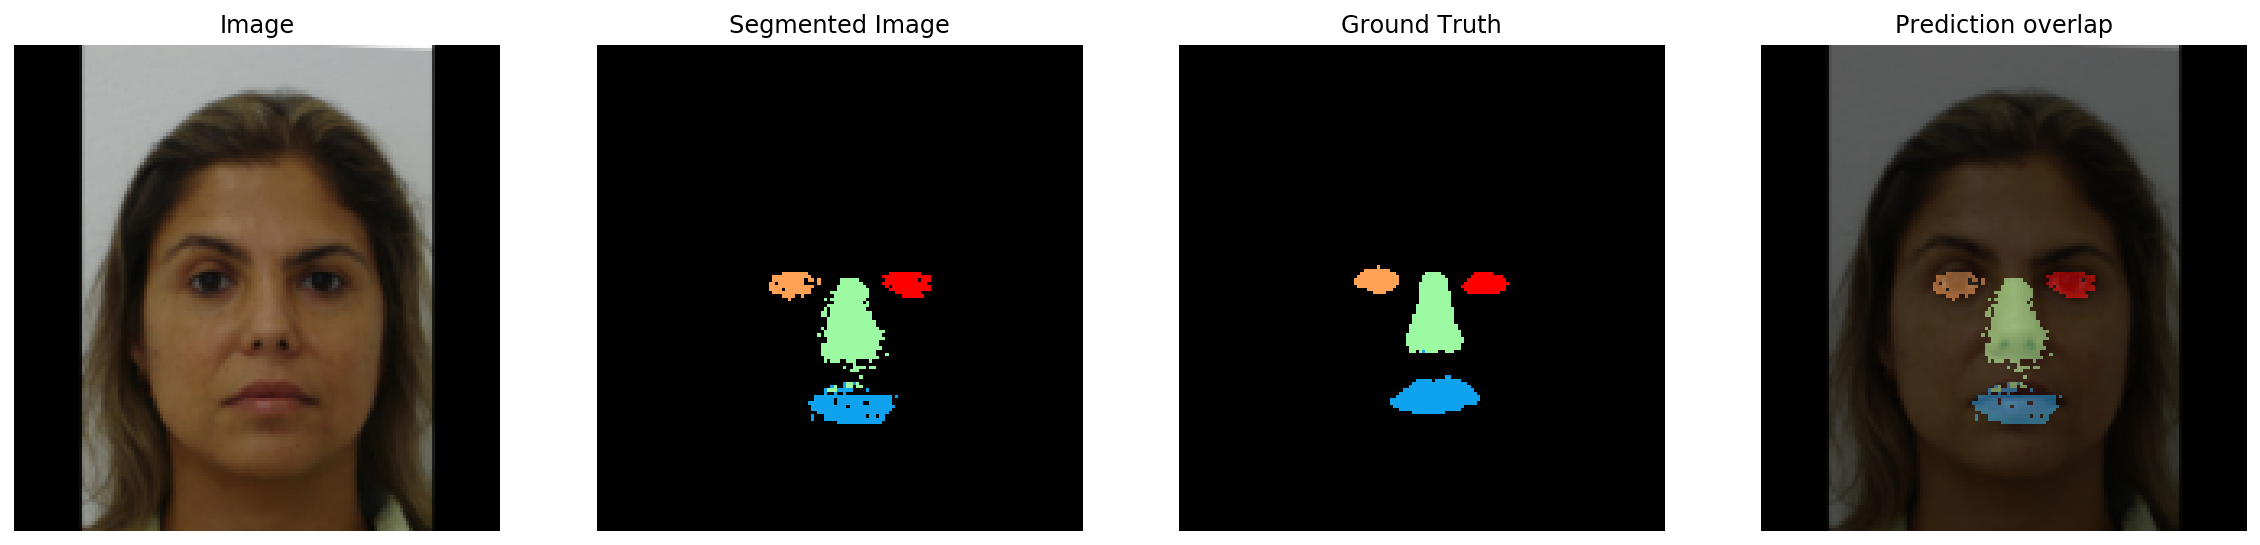

In [196]:
view_prediction(ada_boost, X_test[17], feature_params, overlap=0.5, ground_truth=Y_test[17])

In [166]:
reload_modules()
view_prediction(rfc3, ip.resize_image(real[1], (150,150), preserve_range=False, convert_to_ubyte=True), feature_params)

NameError: name 'real' is not defined

## Function tests / examples


### Segmenting the labels

In [ ]:
# Working out what the top labels are
make_flat = ip.MakeFlat(seg_v2_labels[4].shape)
flat_image = make_flat.transform(seg_v2_labels[4])

pixel_values = [
    f'{pixel[0]}-{pixel[1]}-{pixel[2]}' for pixel in flat_image[:, :3]
]
pixel_values = pd.Series(pixel_values)
pixel_values.value_counts()[:7]

In [ ]:
masked_img = lbp.mask_image(seg_v2_labels[19],
                            criteria='0-255-0',
                            label_dict=label_dict,
                            method='color',
                            return_type='white')
plt.imshow(masked_img)
plt.show()

# Take a look at the image
plt.imshow(seg_v2_labels[19])
plt.show()

In [ ]:
reload_modules()
img_shape = (600,600)
img = ip.convert_images_to_array(seg_v2_v3_labels[50], img_shape, method='zero_pad')
plt.imshow(img)

In [ ]:
seg_img1 = lbp.segment_labeled_image(img, n_clusters = 7, label_dict=label_dict)

In [ ]:
plt.imshow(seg_img1)

In [ ]:
np.unique(seg_img1)

In [ ]:
img= lbp.mask_image(Y[50], 'mouth', label_dict,method='color_label', return_type ='white')
plt.imshow(img)

In [ ]:
plt.imshow(Y[50])

### Downsizing

In [ ]:
def downsize_array(array, factor):
    
    if len(array.shape) <= 3:
        is_gray = True
    else:
        is_gray = False
        
    new_width = int(array.shape[1]*factor)
    if is_gray:
        new_shape = (array.shape[0], new_width, new_width)
    else:
        new_shape = (array.shape[0], new_width, new_width, 3)
    print(new_shape)
        
    downsized_array = np.empty(shape = new_shape)

    for i, img in enumerate(array):
        downsized_array[i] = skimage.transform.resize(img, output_shape = new_shape[1:], order=0, preserve_range=True)
    return downsized_array

In [ ]:
# Test downsizing on an input image
d_img = downsize_array(v2_test_gray, 1/3)
print('shape', v2_test_gray.shape)
plt.imshow(d_img[0], cmap = 'gray')

In [ ]:
# Test downsizing on a segmented image
d_img_seg= downsize_array(v2_test_seg, 1/3)
print('shape', d_img_seg.shape)
plt.imshow(d_img_seg[0])

In [ ]:
np.unique(d_img_seg[0])

### Padding

In [ ]:
reload_modules()
seg_v3_RGB, seg_v3_labels = load_images(seg_v3_RGB_dir, seg_v3_labels_dir)